In [7]:
import pandas as pd
import numpy as np
import torch

In [8]:
ml1m_dir = '/data/vnkljukin/train.csv'
ml1m_rating = pd.read_csv(ml1m_dir)
ml1m_rating.rating += 1
ml1m_rating.rating //= 2
print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))
# Test
test_dir = '/data/vnkljukin/solution.csv'
test_rating = pd.read_csv(test_dir)
test_rating.rating += 1
test_rating.rating //= 2

Range of userId is [0, 42976]
Range of itemId is [0, 328049]


In [9]:
from bert_cnn import BertCNN
from utils import resume_checkpoint

In [10]:
config = {'alias': 'bert_conv_outer_simple_5',
           'num_epoch': 200,
           'batch_size': 2048,
           'optimizer': 'adam',
           'adam_lr': 1e-3,
           'num_users': 42977,
           'num_items': 328050,
           'latent_dim': 64,
           'l2_regularization': 0.,
           'use_cuda': True,
           'device_id': 0,
           'pretrain': False,
           'title_embeddings': '/data/vnkljukin/encoded_bert_128.npy',
           'content_embeddings': None,
           'model_dir': '/data/vnkljukin/checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
           }

In [11]:
bert_cnn = BertCNN(config)
resume_checkpoint(bert_cnn, 
                  '/data/vnkljukin/checkpoints/bert_conv_outer_simple_4_Epoch2_HR0.1862_NDCG0.1952.model', 
                  config['device_id'])

In [33]:
ml1m_rating[ml1m_rating.rating == 0]

,userId,itemId,rating
0,0,206495,0
1,0,279694,0
2,0,19718,0
3,0,74707,0
4,0,221548,0
...,...,...,...
67780163,42976,110624,0
67780164,42976,228542,0
67780165,42976,221362,0
67780166,42976,174323,0


In [46]:
embedding_user = bert_cnn.embedding_user(torch.LongTensor([0]))[0]
embedding_user

tensor([-0.1717,  0.8446, -1.4469, -0.3326,  0.7919, -0.0136, -0.4142, -1.6324,
         0.9632, -1.3776,  0.9781, -0.6464,  1.5389, -0.6001,  0.3175,  1.5729,
        -0.3469,  0.7728, -1.0348,  0.2080,  0.3602, -0.8120,  0.6954,  1.2429,
        -0.0515, -3.1168, -0.0033,  0.7668, -0.7742, -2.2568, -0.9312, -0.3206,
        -0.5102,  0.7581, -1.8322, -0.3268,  0.0696,  1.3459,  1.5709,  0.4434,
         1.6173,  2.0309, -1.2552, -0.5256, -0.6336,  1.0230, -0.3462,  1.0497,
         1.2333,  0.2300, -2.0639,  1.6461,  1.0516,  0.9886,  0.8512,  1.8918,
         0.9129,  0.3340,  0.4865,  0.8359,  1.2063, -1.5758,  1.2167,  0.0328],
       grad_fn=<SelectBackward>)

In [47]:
embedding_item = bert_cnn.item_title(torch.LongTensor([93250]))[0]
embedding_item

tensor([-0.8719,  1.1985, -0.5607,  0.9447,  0.0925, -0.0874,  1.1904,  0.5631,
         1.2309,  1.3596, -0.3879, -0.5028, -0.6219, -0.4787, -0.2760,  1.0199,
         1.0564,  1.0361,  1.8947,  0.1679, -0.7073, -1.4156,  1.3739, -0.7428,
        -1.8705,  0.8361, -1.2331, -0.3459, -0.9374,  3.0337, -0.2374,  2.0981,
        -0.5362,  0.4623,  0.0043, -0.2752,  0.5095, -0.3886, -0.2474, -0.7064,
         0.2939, -0.1585,  0.2723,  1.0128, -0.3277, -0.1618,  1.5827, -3.7812,
         1.1094, -0.2677,  0.3876, -0.3315,  0.4665, -0.4870,  1.1223, -1.2605,
         0.7065, -0.8935,  0.6630, -2.9425, -0.2666, -2.5316,  0.6551, -2.5473,
        -0.9798,  1.4223, -0.1584, -0.3281,  1.8058, -1.0935, -0.7682, -0.1708,
         0.8377, -1.6991,  0.1029,  1.6448,  1.8769,  1.5753, -1.1068, -0.8172,
         0.6123, -0.5178, -0.5431,  0.2460,  0.3630,  1.4030,  0.0599,  0.1597,
        -0.0236,  0.0479, -0.7968, -1.2506,  1.5025, -0.6528, -0.9517, -0.5562,
        -0.2188, -0.1381, -0.0210, -0.09

In [44]:
bert_cnn.eval()
bert_cnn(torch.LongTensor([0]), torch.LongTensor([93250]))

tensor([[0.5453]], grad_fn=<SigmoidBackward>)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

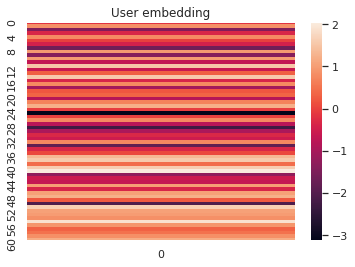

In [26]:
plt.title('User embedding')
sns.heatmap(embedding_user.detach().numpy().reshape(-1, 1))
plt.show()

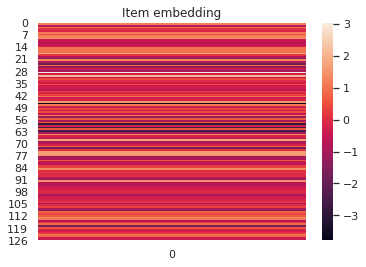

In [27]:
plt.title('Item embedding')
sns.heatmap(embedding_item.detach().numpy().reshape(-1, 1))
plt.show()

In [48]:
outer_map_pos = embedding_user.detach().numpy().reshape(-1, 1) @ embedding_item.detach().numpy().reshape(1, -1)
outer_map_pos.shape

(64, 128)

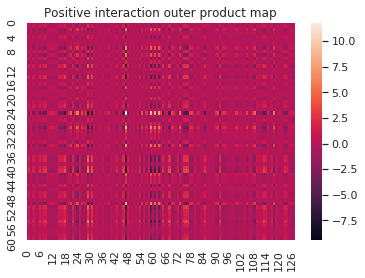

In [43]:
plt.title('Positive interaction outer product map')
sns.heatmap(outer_map)
plt.show()

In [49]:
embedding_user = bert_cnn.embedding_user(torch.LongTensor([0]))[0]
embedding_item = bert_cnn.item_title(torch.LongTensor([221548]))[0]
outer_map_neg = embedding_user.detach().numpy().reshape(-1, 1) @ embedding_item.detach().numpy().reshape(1, -1)

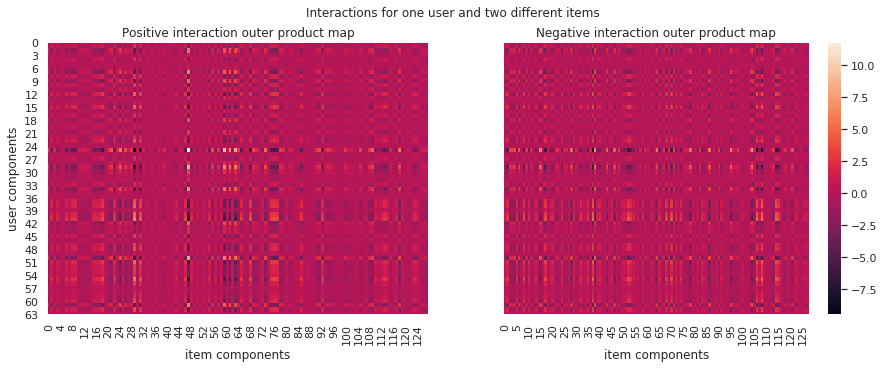

In [77]:
vmin = min(outer_map_neg.min(), outer_map_pos.min())
vmax = max(outer_map_neg.max(), outer_map_pos.max())

plt.figure(figsize=(15, 5))
plt.suptitle('Interactions for one user and two different items')
plt.subplot(1, 2, 1)
plt.title('Positive interaction outer product map')
sns.heatmap(outer_map_pos, vmin=vmin, vmax=vmax, cbar=False)
plt.ylabel('user components')
plt.xlabel('item components')

plt.subplot(1, 2, 2)
plt.title('Negative interaction outer product map')
g2 = sns.heatmap(outer_map_neg, vmin=vmin, vmax=vmax)
g2.set_yticks([])
plt.xlabel('item components')
plt.savefig('/data/vnkljukin/outer_maps.png')
plt.show()

In [78]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [124]:
!ls runs

bert_conv_outer_simple	  gmf_factor8-implicit_2nd
bert_conv_outer_simple_2  gmf_factor8-implict
bert_conv_outer_simple_3  mlp_factor8_bs256_reg_0.0000001
bert_conv_outer_simple_4  mlp_factor8_bs512_reg_1e-7
bert_conv_outer_simple_5  pretrain_neumf_factor16
bert_neumf_title	  w2v_neumf_title


In [102]:
from collections import defaultdict

In [109]:
gmf_factor8_implicit = defaultdict(list)
for event in summary_iterator("runs/gmf_factor8-implict/events.out.tfevents.1586691393.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            gmf_factor8_implicit[item].append(value.simple_value)
gmf_factor8_implicit

defaultdict(list,
            {'loss': [21008.7890625, 20807.931640625, 20793.00390625],
             'HR': [0.14617736637592316,
              0.1413256824016571,
              0.14069335162639618],
             'NDCG': [0.14696359634399414,
              0.142063170671463,
              0.14034992456436157]})

In [112]:
mlp_factor8_bs512_reg_1e_7 = defaultdict(list)
for event in summary_iterator("runs/mlp_factor8_bs512_reg_1e-7/events.out.tfevents.1586781182.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            mlp_factor8_bs512_reg_1e_7[item].append(value.simple_value)
mlp_factor8_bs512_reg_1e_7

defaultdict(list,
            {'loss': [38847.94921875, 38176.75390625, 38145.01171875],
             'HR': [0.16735465824604034,
              0.1668487936258316,
              0.16617047786712646],
             'NDCG': [0.17810460925102234,
              0.17792120575904846,
              0.17746004462242126]})

In [120]:
pretrain_neumf_factor16 = defaultdict(list)
for event in summary_iterator("runs/pretrain_neumf_factor16/events.out.tfevents.1586805539.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            pretrain_neumf_factor16[item].append(value.simple_value)
pretrain_neumf_factor16

defaultdict(list,
            {'loss': [18820.033203125,
              18732.001953125,
              18723.11328125,
              18701.587890625,
              18684.283203125,
              18675.166015625,
              18668.369140625,
              18653.697265625,
              18634.98828125,
              18622.15625,
              18613.662109375,
              18601.109375,
              18590.109375,
              18586.587890625],
             'HR': [0.167757049202919,
              0.16675680875778198,
              0.1688377559185028,
              0.16912516951560974,
              0.16368713974952698,
              0.16261793673038483,
              0.1655726283788681,
              0.17034384608268738,
              0.17176945507526398,
              0.16959655284881592,
              0.1703898310661316,
              0.17148204147815704,
              0.17140156030654907,
              0.17139005661010742],
             'NDCG': [0.1805049180984497,
              0.1

In [123]:
w2v_neumf_title = defaultdict(list)
for event in summary_iterator("runs/w2v_neumf_title/events.out.tfevents.1586883854.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            w2v_neumf_title[item].append(value.simple_value)
w2v_neumf_title

defaultdict(list,
            {'loss': [77609.5546875, 76479.53125, 76286.265625],
             'HR': [0.06805596500635147, 0.03580716997385025],
             'NDCG': [0.06222138553857803, 0.029926124960184097]})

In [142]:
!ls runs/bert_conv_outer_simple_5

events.out.tfevents.1587039946.almaren.velkerr.ru
events.out.tfevents.1587040797.almaren.velkerr.ru


In [127]:
bert_neumf_title = defaultdict(list)
for event in summary_iterator("runs/bert_neumf_title/events.out.tfevents.1586901360.imladris"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            bert_neumf_title[item].append(value.simple_value)
bert_neumf_title

defaultdict(list,
            {'loss': [16071.447265625,
              15755.111328125,
              15684.4228515625,
              15643.310546875,
              15609.9853515625,
              15578.6181640625,
              15548.42578125,
              15514.5185546875,
              15478.8701171875,
              15445.2578125,
              15410.1201171875,
              15379.16796875,
              15345.83984375,
              15311.7783203125,
              15279.5322265625],
             'HR': [0.17319507896900177,
              0.17464368045330048,
              0.1694815754890442,
              0.16450342535972595,
              0.1607324331998825,
              0.15384580194950104,
              0.15352389216423035,
              0.15168438851833344,
              0.14895962178707123,
              0.14959195256233215,
              0.147051140666008,
              0.14591294527053833,
              0.14646479487419128,
              0.1466832309961319],
             

In [131]:
bert_conv_outer_simple_all = defaultdict(list)
for event in summary_iterator("runs/bert_conv_outer_simple/events.out.tfevents.1586973914.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            bert_conv_outer_simple_all[item].append(value.simple_value)
bert_conv_outer_simple_all

defaultdict(list,
            {'loss': [7940.7060546875, 7787.32080078125],
             'HR': [0.17435626685619354, 0.1707577407360077],
             'NDCG': [0.18397513031959534, 0.18122072517871857]})

In [135]:
bert_conv_outer_simple_5x = defaultdict(list)
for event in summary_iterator("runs/bert_conv_outer_simple_2/events.out.tfevents.1586984604.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            bert_conv_outer_simple_5x[item].append(value.simple_value)
bert_conv_outer_simple_5x

defaultdict(list,
            {'loss': [9533.9521484375,
              9325.7783203125,
              9277.5048828125,
              9237.501953125],
             'HR': [0.16156022250652313,
              0.14929303526878357,
              0.14801687002182007,
              0.14438384771347046],
             'NDCG': [0.16972243785858154,
              0.15459010004997253,
              0.15148192644119263,
              0.1455972045660019]})

In [137]:
bert_conv_outer_simple_2x = defaultdict(list)
for event in summary_iterator("runs/bert_conv_outer_simple_3/events.out.tfevents.1587024598.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            bert_conv_outer_simple_2x[item].append(value.simple_value)
bert_conv_outer_simple_2x

defaultdict(list,
            {'loss': [5887.576171875,
              5780.373046875,
              5724.626953125,
              5621.9541015625,
              5441.55029296875],
             'HR': [0.18055309355258942,
              0.18330085277557373,
              0.18233510851860046,
              0.17273519933223724,
              0.15774324536323547],
             'NDCG': [0.1904315948486328,
              0.1930476874113083,
              0.1915818154811859,
              0.18147623538970947,
              0.16170856356620789]})

In [141]:
bert_conv_outer_simple_1x = defaultdict(list)
for event in summary_iterator("runs/bert_conv_outer_simple_4/events.out.tfevents.1587031716.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            bert_conv_outer_simple_1x[item].append(value.simple_value)
bert_conv_outer_simple_1x

defaultdict(list,
            {'loss': [4310.3623046875,
              4227.10791015625,
              4190.26123046875,
              4148.9033203125,
              4077.403076171875,
              3966.093994140625,
              3832.886474609375,
              3697.2958984375,
              3576.66015625,
              3468.236572265625,
              3374.125],
             'HR': [0.17954136431217194,
              0.1849564015865326,
              0.18624405562877655,
              0.18348479270935059,
              0.17887453734874725,
              0.1721833497285843,
              0.15888144075870514,
              0.15775474905967712,
              0.15531739592552185,
              0.1526041328907013],
             'NDCG': [0.18735747039318085,
              0.19382606446743011,
              0.1951964646577835,
              0.19230030477046967,
              0.1869117170572281,
              0.17893105745315552,
              0.16092956066131592,
              0.1599820107

In [144]:
bert_conv_outer_simple_0_5x = defaultdict(list)
for event in summary_iterator("runs/bert_conv_outer_simple_5/events.out.tfevents.1587040797.almaren.velkerr.ru"):
    for value in event.summary.value:
        cause, item = value.tag.split('/')
        if item in ('loss', 'HR', 'NDCG'):
            bert_conv_outer_simple_0_5x[item].append(value.simple_value)
bert_conv_outer_simple_0_5x

defaultdict(list,
            {'loss': [2980.46630859375,
              2920.636474609375,
              2894.155517578125,
              2868.08349609375,
              2831.14111328125,
              2772.625732421875,
              2692.06982421875,
              2605.083740234375,
              2521.771484375,
              2448.13037109375],
             'HR': [0.17816174030303955,
              0.1837262362241745,
              0.18493340909481049,
              0.1844160407781601,
              0.18376071751117706,
              0.18111643195152283,
              0.17531050741672516,
              0.16361816227436066,
              0.1628248691558838,
              0.16167518496513367],
             'NDCG': [0.18566842377185822,
              0.19174160063266754,
              0.19334185123443604,
              0.19243541359901428,
              0.1917293667793274,
              0.18857170641422272,
              0.18224892020225525,
              0.16702425479888916,
          

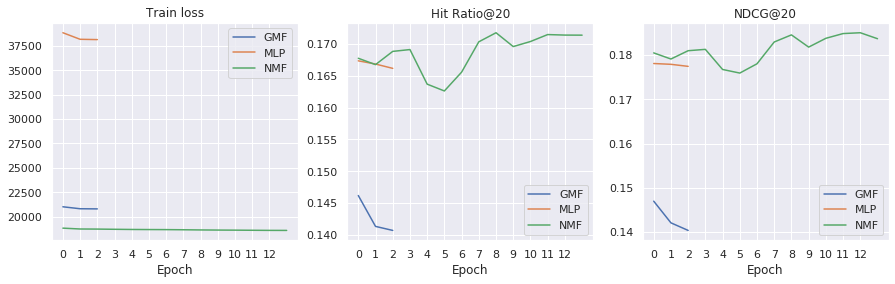

In [152]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Train loss')
plt.plot(gmf_factor8_implicit['loss'], label='GMF')
plt.plot(mlp_factor8_bs512_reg_1e_7['loss'], label='MLP')
plt.plot(pretrain_neumf_factor16['loss'], label='NMF')
plt.xticks(list(range(13)))
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Hit Ratio@20')
plt.plot(gmf_factor8_implicit['HR'], label='GMF')
plt.plot(mlp_factor8_bs512_reg_1e_7['HR'], label='MLP')
plt.plot(pretrain_neumf_factor16['HR'], label='NMF')
plt.xticks(list(range(13)))
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.title('NDCG@20')
plt.plot(gmf_factor8_implicit['NDCG'], label='GMF')
plt.plot(mlp_factor8_bs512_reg_1e_7['NDCG'], label='MLP')
plt.plot(pretrain_neumf_factor16['NDCG'], label='NMF')
plt.xticks(list(range(13)))
plt.xlabel('Epoch')
plt.legend()

plt.savefig('/data/vnkljukin/baselines_recsys.png')
plt.show()

In [153]:
baseline_hr = max(pretrain_neumf_factor16['HR'])
baseline_ndcg = max(pretrain_neumf_factor16['NDCG'])
baseline_hr, baseline_ndcg

(0.17176945507526398, 0.18506324291229248)

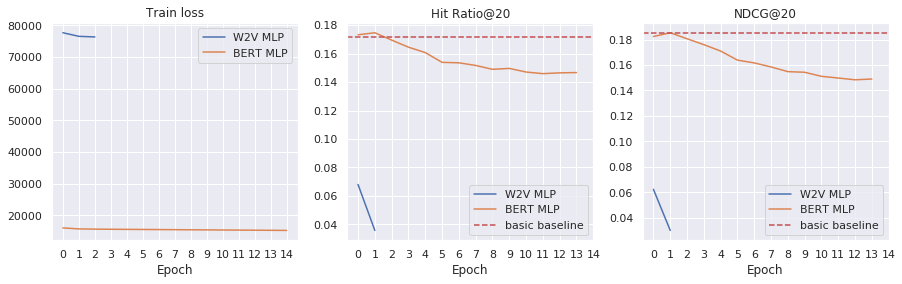

In [165]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Train loss')
plt.plot(w2v_neumf_title['loss'], label='W2V MLP')
plt.plot(bert_neumf_title['loss'], label='BERT MLP')
plt.xticks(list(range(15)))
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Hit Ratio@20')
plt.plot(w2v_neumf_title['HR'], label='W2V MLP')
plt.plot(bert_neumf_title['HR'], label='BERT MLP')
plt.axhline(baseline_hr, color='r', linestyle='dashed', label='basic baseline')
plt.xticks(list(range(15)))
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.title('NDCG@20')
plt.plot(w2v_neumf_title['NDCG'], label='W2V MLP')
plt.plot(bert_neumf_title['NDCG'], label='BERT MLP')
plt.axhline(baseline_ndcg, color='r', linestyle='dashed', label='basic baseline')
plt.xticks(list(range(15)))
plt.xlabel('Epoch')
plt.legend()

plt.savefig('/data/vnkljukin/bert_w2v_recsys.png')
plt.show()

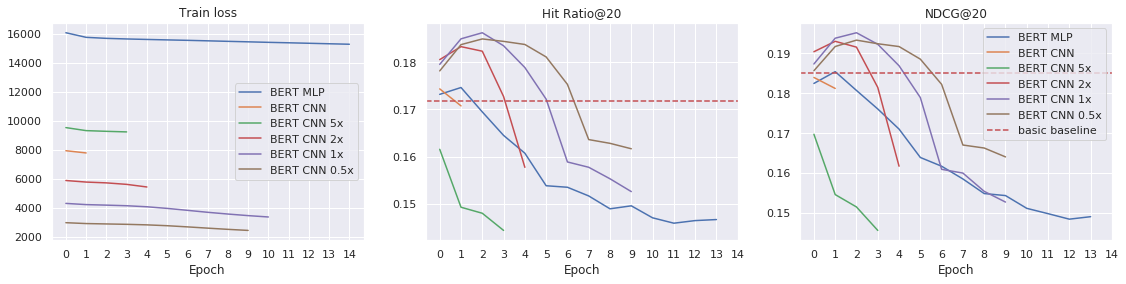

In [172]:
plt.figure(figsize=(19, 4))
plt.subplot(1, 3, 1)
plt.title('Train loss')
plt.plot(bert_neumf_title['loss'], label='BERT MLP')
plt.plot(bert_conv_outer_simple_all['loss'], label='BERT CNN')
plt.plot(bert_conv_outer_simple_5x['loss'], label='BERT CNN 5x')
plt.plot(bert_conv_outer_simple_2x['loss'], label='BERT CNN 2x')
plt.plot(bert_conv_outer_simple_1x['loss'], label='BERT CNN 1x')
plt.plot(bert_conv_outer_simple_0_5x['loss'], label='BERT CNN 0.5x')

plt.xticks(list(range(15)))
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Hit Ratio@20')
plt.plot(bert_neumf_title['HR'], label='BERT MLP')
plt.plot(bert_conv_outer_simple_all['HR'], label='BERT CNN')
plt.plot(bert_conv_outer_simple_5x['HR'], label='BERT CNN 5x')
plt.plot(bert_conv_outer_simple_2x['HR'], label='BERT CNN 2x')
plt.plot(bert_conv_outer_simple_1x['HR'], label='BERT CNN 1x')
plt.plot(bert_conv_outer_simple_0_5x['HR'], label='BERT CNN 0.5x')
plt.axhline(baseline_hr, color='r', linestyle='dashed', label='basic baseline')
plt.xticks(list(range(15)))
plt.xlabel('Epoch')
# plt.legend()

plt.subplot(1, 3, 3)
plt.title('NDCG@20')
plt.plot(bert_neumf_title['NDCG'], label='BERT MLP')
plt.plot(bert_conv_outer_simple_all['NDCG'], label='BERT CNN')
plt.plot(bert_conv_outer_simple_5x['NDCG'], label='BERT CNN 5x')
plt.plot(bert_conv_outer_simple_2x['NDCG'], label='BERT CNN 2x')
plt.plot(bert_conv_outer_simple_1x['NDCG'], label='BERT CNN 1x')
plt.plot(bert_conv_outer_simple_0_5x['NDCG'], label='BERT CNN 0.5x')
plt.axhline(baseline_ndcg, color='r', linestyle='dashed', label='basic baseline')
plt.xticks(list(range(15)))
plt.xlabel('Epoch')
plt.legend()

plt.savefig('/data/vnkljukin/bert_cnn_recsys.png')
plt.show()